# Part 0: Import Libraries and Prepare Data for Training 

In [1]:
import sagemaker
sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = 'sagemaker/arvato-batch'

role = sagemaker.get_execution_role()

In [2]:
import boto3
import sagemaker.amazon.common as smac
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.transformer import Transformer
from sagemaker.predictor import csv_serializer, json_deserializer
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.sparse
import os
import json

In [15]:
!mkdir ./data/scaled_raw/
!aws s3 cp s3://sagemaker-us-east-1-873710589365/sagemaker/arvato/pca_batch/train/Azdias_scaled.csv ./data/scaled_raw/

download: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato/pca_batch/train/Azdias_scaled.csv to data/scaled_raw/Azdias_scaled.csv


In [4]:
def load_scaled_raw(): 
    azdias = pd.read_csv('./data/scaled_raw/Azdias_scaled.csv', sep=',')
    customers = pd.read_csv('./data/scaled_raw/Customers_scaled.csv', sep=',')
    #customers = pd.read_csv('./data/scaled_raw/Customers_scaled.csv', sep=',')
    return azdias, customers

In [5]:
azdias_scaled, customers_scaled = load_scaled_raw()

(134246, 352)

In [6]:
# Sanitory check for azdias_scaled.shape and customers_scaled.shape
print(azdias_scaled.shape)
print(customers_scaled.shape)

(241114, 352)
(134246, 352)


In [7]:
azdias_scaled

AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0         1.259814 -1.434149              1.561893             0.190422   
1         1.259814  0.797345              0.673033             0.123911   
2        -0.936226  0.272287             -0.215827            -0.474689   
3        -0.936226  1.191138              0.006388            -0.341667   
4        -0.936226 -0.121506             -0.882472            -0.208645   
...            ...       ...                   ...                  ...   
241109   -0.936226 -1.434149              0.228603             1.387624   
241110    0.161794 -1.434149              0.228603            -0.142133   
241111    1.259814  0.928609              0.895248             0.589489   
241112    1.259814  0.797345              0.673033             1.786691   
241113   -0.936226 -1.434149              0.228603             1.786691   

        ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0          -0.124437   -0.301247      0.218853                    0.342117   
1          -0.124437   -0.301247     -0.633778                   -0.028879   
2          -0.124437   -0.301247     -1.486409                   -0.399876   
3          -0.124437   -0.301247      1.924115                   -0.325676   
4          -0.124437   -0.301247     -0.633778                   -0.399876   
...              ...         ...           ...                         ...   
241109     -0.124437   -0.301247     -0.633778                    1.232508   
241110     -0.124437   -0.301247     -0.633778                   -0.177278   
241111     -0.124437   -0.301247     -0.633778                    0.935711   
241112     -0.124437   -0.301247     -0.633778                    1.974500   
241113     -0.124437   -0.301247     -1.486409                    1.974500   

        ANZ_TITEL    ARBEIT  ...   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0       -0.060155 -0.158990  ...  1.444672       -0.741360        0.548627   
1       -0.060155 -0.158990  ...  0.012817       -0.741360        0.548627   
2       -0.060155 -1.161990  ...  1.802635        0.955435        0.548627   
3       -0.060155  0.844011  ... -0.703111       -1.306958        0.548627   
4       -0.060155 -1.161990  ... -0.703111        0.955435        0.548627   
...           ...       ...  ...       ...             ...             ...   
241109  -0.060155 -1.161990  ...  0.370781        0.389837       -1.039471   
241110  -0.060155  0.844011  ...  0.728744       -0.175762       -2.627569   
241111  -0.060155  0.844011  ...  0.370781        0.955435        0.548627   
241112  -0.060155 -0.158990  ...  0.728744        0.389837        0.548627   
241113  -0.060155 -0.158990  ...  0.370781        0.955435       -0.510105   

        WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB      Temp  \
0      -0.024663  1.145195   0.956843             -1.676427  0.448662   
1      -1.079293  1.145195   0.956843              0.168611 -0.993454   
2       1.557283 -0.274060   0.956843              1.091130 -1.153689   
3      -0.551978  0.435567  -1.045103              0.168611  1.329955   
4       1.557283  0.435567   0.956843             -1.676427 -0.592866   
...          ...       ...        ...                   ...       ...   
241109 -0.551978 -0.274060  -1.045103              0.168611 -0.833218   
241110 -1.079293 -0.274060   0.956843              0.168611 -0.672983   
241111 -0.551978  1.145195  -1.045103             -0.753908 -1.153689   
241112 -0.024663  1.145195  -1.045103             -1.676427 -0.913336   
241113 -0.024663 -0.274060  -1.045103              1.091130 -1.153689   

        CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_FAMILY  
0                     1.174229               -1.250353  
1                    -0.871690                0.768488  
2                    -1.553663               -0.577406  
3                     0.492256                0.095541  
4                     1.174229                0.768488  
...           

In [8]:
azdias_scaled_np = pd.DataFrame(azdias_scaled).to_numpy()
azdias_scaled_np

array([[ 1.25981368, -1.43414943,  1.56189275, ...,  0.44866202,
         1.17422935, -1.25035261],
       [ 1.25981368,  0.79734466,  0.67303274, ..., -0.99345351,
        -0.87168964,  0.76848809],
       [-0.93622626,  0.27228723, -0.21582727, ..., -1.15368856,
        -1.55366264, -0.57740571],
       ...,
       [ 1.25981368,  0.92860902,  0.89524775, ..., -1.15368856,
         1.17422935, -1.25035261],
       [ 1.25981368,  0.79734466,  0.67303274, ..., -0.91333598,
         1.17422935, -1.25035261],
       [-0.93622626, -1.43414943,  0.22860274, ..., -1.15368856,
         1.17422935, -1.25035261]])

In [9]:
scaled_noheader_dir = 'data/scaled_noheader'

if not os.path.exists(scaled_noheader_dir):
    os.makedirs(scaled_noheader_dir)

azdias_scaled.to_csv('./data/scaled_noheader/Azdias_scaled_noheader.csv', header=False, index=False)

In [10]:
customers_scaled.to_csv('./data/scaled_noheader/Customers_scaled_noheader.csv', header=False, index=False)

In [11]:
def load_scaled_noheader(): 
    azdias = pd.read_csv('./data/scaled_noheader/Azdias_scaled_noheader.csv', sep=',')
    customers = pd.read_csv('./data/scaled_noheader/Customers_scaled_noheader.csv', sep=',')
    return azdias, customers

In [13]:
azdias_scaled_noheader, customers_scaled_noheader = load_scaled_noheader()

In [15]:
# Sanitory check 
print(azdias_scaled_noheader.shape)
print(customers_scaled_noheader.shape)

(241113, 352)
(134245, 352)


In [16]:
azdias_scaled_noheader

1.2598136782105085  -1.4341494346161143  1.5618927532380669  \
0                 1.259814             0.797345            0.673033   
1                -0.936226             0.272287           -0.215827   
2                -0.936226             1.191138            0.006388   
3                -0.936226            -0.121506           -0.882472   
4                 1.259814            -1.434149            0.228603   
...                    ...                  ...                 ...   
241108           -0.936226            -1.434149            0.228603   
241109            0.161794            -1.434149            0.228603   
241110            1.259814             0.928609            0.895248   
241111            1.259814             0.797345            0.673033   
241112           -0.936226            -1.434149            0.228603   

        0.1904224734001811  -0.12443722549513997  -0.3012471350924804  \
0                 0.123911             -0.124437            -0.301247   
1                -0.474689             -0.124437            -0.301247   
2                -0.341667             -0.124437            -0.301247   
3                -0.208645             -0.124437            -0.301247   
4                -0.275156             -0.124437            -0.301247   
...                    ...                   ...                  ...   
241108            1.387624             -0.124437            -0.301247   
241109           -0.142133             -0.124437            -0.301247   
241110            0.589489             -0.124437            -0.301247   
241111            1.786691             -0.124437            -0.301247   
241112            1.786691             -0.124437            -0.301247   

        0.2188528410768922  0.3421168010054085  -0.06015504326651345  \
0                -0.633778           -0.028879             -0.060155   
1                -1.486409           -0.399876             -0.060155   
2                 1.924115           -0.325676             -0.060155   
3                -0.633778           -0.399876             -0.060155   
4                -0.633778           -0.325676             -0.060155   
...                    ...                 ...                   ...   
241108           -0.633778            1.232508             -0.060155   
241109           -0.633778           -0.177278             -0.060155   
241110           -0.633778            0.935711             -0.060155   
241111           -0.633778            1.974500             -0.060155   
241112           -1.486409            1.974500             -0.060155   

        -0.1589898434513409  ...  1.4446717118415646  -0.7413600151648706  \
0                 -0.158990  ...            0.012817            -0.741360   
1                 -1.161990  ...            1.802635             0.955435   
2                  0.844011  ...           -0.703111            -1.306958   
3                 -1.161990  ...           -0.703111             0.955435   
4                  0.844011  ...            1.444672            -0.741360   
...                     ...  ...                 ...                  ...   
241108            -1.161990  ...            0.370781             0.389837   
241109             0.844011  ...            0.728744            -0.175762   
241110             0.844011  ...            0.370781             0.955435   
241111            -0.158990  ...            0.728744             0.389837   
241112            -0.158990  ...            0.370781             0.955435   

        0.54862709637808  -0.02466274258018451  1.145194617001632  \
0               0.548627             -1.079293           1.145195   
1               0.548627              1.557283          -0.274060   
2               0.548627             -0.551978           0.435567   
3               0.548627              1.557283           0.435567   
4               0.548627              0.502652           0.435567   
...                  ...                   ...                ...   
24110

In [17]:
customers_scaled_noheader

-0.3678580348837494  -0.21612886780667231  -0.10022442398271246  \
0                 -0.367858             -0.855203             -2.529358   
1                 -0.367858             -0.535666             -0.586051   
2                 -0.367858              1.381556              0.871429   
3                 -0.367858             -0.056360             -0.100224   
4                 -0.367858             -0.216129             -0.100224   
...                     ...                   ...                   ...   
134240            -0.367858             -0.375897             -0.343138   
134241             0.155422             -1.813814             -2.529358   
134242            -0.367858              0.582714             -0.100224   
134243            -0.367858              0.263177              0.628516   
134244            -0.367858             -1.813814             -0.343138   

        -0.27480245594907  -0.1249602910998794  -0.26531812070256505  \
0               -0.274802             -0.12496             -0.265318   
1               -0.347719             -0.12496             -0.265318   
2                0.162700             -0.12496             -0.265318   
3               -0.274802             -0.12496             -0.265318   
4               -0.274802             -0.12496             -0.265318   
...                   ...                  ...                   ...   
134240          -0.274802             -0.12496             -0.265318   
134241          -0.347719             -0.12496             -0.265318   
134242          -0.274802             -0.12496             -0.265318   
134243          -0.056051             -0.12496             -0.265318   
134244          -0.274802             -0.12496             -0.265318   

        -0.20728333379010724  -0.2578658475471041  -0.13472553576065469  \
0                  -0.921821            -0.257866             -0.134726   
1                  -1.636359            -0.257866             -0.134726   
2                   1.221792             0.185989             -0.134726   
3                  -0.207283            -0.257866             -0.134726   
4                  -0.207283            -0.257866             -0.134726   
...                      ...                  ...                   ...   
134240             -0.921821            -0.257866             -0.134726   
134241             -1.636359            -0.257866             -0.134726   
134242              0.507254            -0.257866             -0.134726   
134243              1.221792            -0.109914             -0.134726   
134244              0.507254            -0.257866             -0.134726   

        -1.813374341807068  ...  -0.5125911337870968  0.8675453397850297  \
0                 0.164231  ...             3.420572            0.867545   
1                -1.813374  ...            -0.512591            0.867545   
2                 0.164231  ...             0.361445           -1.281187   
3                 0.164231  ...            -0.949609            0.867545   
4                -0.824572  ...            -0.512591            0.867545   
...                    ...  ...                  ...                 ...   
134240            0.164231  ...             0.798463            0.867545   
134241           -1.813374  ...             0.361445            0.867545   
134242            0.164231  ...             0.798463           -0.744004   
134243            0.164231  ...            -0.949609           -0.206821   
134244           -1.813374  ...            -0.949609           -0.744004   

        0.2739038714959509  1.5836857915514346  0.4624906831499938  \
0                 0.273904           -0.836801            0.462491   
1                 0.273904            1.583686           -1.073113   
2                 0.273904           -0.352704           -1.073113   
3                 0.273904           -1.320899           -0.305311   
4                 0.273904            1.583686           -1.073113   
...     

# Part 1: Dimensionality Reduction by PCA

## Load scaled data into S3 

Dimensionality reduction and clustering don't always require a holdout set to test accuracy. Therefore, we'll not setup to split our dataset into train and test but to use the whole population dataset, azdias, as the training data.

In [18]:
train_s3 = sess.upload_data('./data/scaled_noheader/Azdias_scaled_noheader.csv', 
                            bucket=bucket, 
                            key_prefix='{}/pca_batch/train/noheader'.format(prefix))

#test_s3 = sess.upload_data('Customers_scaled.csv',
#                           bucket=bucket,
#                           key_prefix='{}/pca_batch/test'.format(prefix))

We'll create an input which can be passed to our SageMaker training estimator.

In [19]:
train_inputs = sagemaker.s3_input(train_s3, content_type='text/csv; label_size=0')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


## Perform initial PCA 

We'll use PCA to generate a much smaller number of uncorrelated components. This should make finding clusters easier.

Let's start by creating a PCA estimator. We'll define:

- Algorithm container path
- IAM role for data permissions and
- Harware setup (instance count and type)
- Output path (where our PCA model artifact will be saved)

In [20]:
container = get_image_uri(boto3.Session().region_name, 'pca', 'latest')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [21]:
pca = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/pca_batch/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Then we can define hyperparameters like:

- feature_dim: The number of features (in this case users) in our input dataset.
- num_components: The number of features we want in our output dataset (which we'll pass to our clustering algorithm as input).
- subtract_mean: Debiases our features before running PCA.
- algorithm_mode: Since our dataset is rather large, we'll use randomized, which scales better.

In [80]:
feature_dim = azdias_scaled_noheader.shape[1]
num_components = azdias_scaled_noheader.shape[1] - 1
print(feature_dim)
print(num_components)

352
351


In [81]:
pca.set_hyperparameters(feature_dim=feature_dim,
                        num_components=feature_dim-1,
                        subtract_mean=True,
                        algorithm_mode='regular',
                        mini_batch_size=200)

And finally, we'll use .fit() to start the training job.

In [82]:
pca.fit({'train': train_inputs})

2020-11-02 21:47:18 Starting - Starting the training job...
2020-11-02 21:47:20 Starting - Launching requested ML instances......
2020-11-02 21:48:32 Starting - Preparing the instances for training......
2020-11-02 21:49:35 Downloading - Downloading input data.........
2020-11-02 21:51:06 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2020 21:51:29 INFO 140422915065664] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[11/02/2020 21:51:29 INFO 140422915065664] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'algorithm_mode': u'regular', u'feature_dim': u'352', 


2020-11-02 21:51:26 Training - Training image download completed. Training in progress.
2020-11-02 21:52:17 Uploading - Uploading generated training model#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 42900.80499649048, "sum": 42900.80499649048, "min": 42900.80499649048}}, "EndTime": 1604353933.807045, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1604353890.905804}

[11/02/2020 21:52:13 INFO 140422915065664] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1206, "sum": 1206.0, "min": 1206}, "Number of Batches Since Last Reset": {"count": 1, "max": 1206, "sum": 1206.0, "min": 1206}, "Number of Records Since Last Reset": {"count": 1, "max": 241114, "sum": 241114.0, "min": 241114}, "Total Batches Seen": {"count": 1, "max": 1206, "sum": 1206.0, "min": 1206}, "Total Records Seen": {"count": 1, "

## Batch prediction PCA

Our PCA training job has finished, let's generate some predictions from it. We'll start by creating a batch transformer. 

- Hardware specification (i.e., instance count and type): Prediction is embarassingly parallel. Since our dataset is not enormous, we'll stick to 1.
- strategy: Which determines how records should be batched into each prediction request within the batch transform job. 'MultiRecord' may be faster, but some use cases may require 'SingleRecord'.
- assemble_with: Which controls how predictions are output. 'None' does not perform any special processing, 'Line' places each prediction on it's own line.
- output_path: The S3 location for batch transform to be output. Note, file(s) will be named with '.out' suffixed to the input file(s) names. 

In [83]:
pca_transformer = pca.transformer(instance_count=1,
                                  instance_type='ml.m4.xlarge',
                                  strategy='MultiRecord',
                                  assemble_with='Line',
                                  #output_path='s3://{}/{}/pca/transform/train'.format(bucket, prefix)
                                  output_path='s3://{}/{}/pca_batch/output/transformed'.format(bucket, prefix))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


We'll pass our training data in to get predictions from batch transformer. A critical parameter to set properly here is split_type. Since we are using CSV, we'll specify 'Line', which ensures we only pass one line at a time to our algorithm for prediction. 

We will pass the S3 path as input rather than input we use in .fit()

In [84]:
pca_transformer.transform(train_s3, content_type='text/csv', split_type='Line')
pca_transformer.wait()

................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2020 22:02:05 INFO 139806759171904] loaded entry point class algorithm.serve.server_config:config_api
[11/02/2020 22:02:05 INFO 139806759171904] nvidia-smi took: 0.025190114975 secs to identify 0 gpus
[11/02/2020 22:02:05 INFO 139806759171904] loading entry points
[11/02/2020 22:02:05 INFO 139806759171904] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[11/02/2020 22:02:05 INFO 139806759171904] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[11/02/2020 22:02:05 INFO 139806759171904] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[11/02/2020 22:02:05 INFO 139806759171904] loaded request

2020-11-02T22:02:05.771:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[11/02/2020 22:02:14 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:14 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604354534.4631, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604354533.028634}

[11/02/2020 22:02:14 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:02:14 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:02:14 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:14 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max":

[11/02/2020 22:02:48 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:02:48 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:48 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604354568.59887, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604354567.010564}

[11/02/2020 22:02:48 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:02:48 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:02:48 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:48 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:02:48 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:48 INFO 139806759171904] <PCAM

[11/02/2020 22:02:59 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:02:59 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:02:59 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:59 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604354579.603194, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604354577.599021}

[11/02/2020 22:02:59 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:02:59 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:02:59 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:02:59 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch sl

[11/02/2020 22:03:09 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:09 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:09 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/02/2020 22:03:09 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:09 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:09 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604354589.393218, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604354588.051271}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604354589.667998, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 

[11/02/2020 22:03:18 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:18 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:18 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:18 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604354598.886338, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604354597.231885}

[11/02/2020 22:03:19 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:19 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:18 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:18 INFO 139806759171904] Number of GP

[11/02/2020 22:03:34 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:34 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/02/2020 22:03:34 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:34 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/02/2020 22:03:34 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:34 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:34 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:34 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:34 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:34 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/02/2020 22:03:34 WARNING 

[11/02/2020 22:03:44 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:44 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/02/2020 22:03:44 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:44 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:44 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:44 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/02/2020 22:03:45 WARNING 139806759171904] Requesting context without setting the requested num of gpus. Using 'auto'
[11/02/2020 22:03:45 INFO 139806759171904] Number of GPUs being used: 0
[11/02/2020 22:03:45 INFO 139806759171904] The default executor is <PCAModel on cpu(0)>.
[11/02/2020 22:03:45 INFO 139806759171904] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invoca

Our batch transform job has completed, let's take a look at the output. 

## Retrieve and assess PCA model attributes

Since we've reduced the dimensionality so much, the output is reasonably small and we can just download it locally.

In [85]:
!aws s3 cp --recursive $pca_transformer.output_path ./

download: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/pca_batch/output/transformed/Azdias_scaled_noheader.csv.out to ./Azdias_scaled_noheader.csv.out


In [86]:
!head Azdias_scaled_noheader.csv.out

{"projection":[0.006887068971991,0.002957705175504,0.085419438779354,-0.001972892088815,-0.155494377017021,-0.008198228664696,-0.009037470445036,0.475056082010269,-0.057427279651165,0.010265910997986,0.310701370239257,-0.16416597366333,-0.141487404704093,-0.079346925020217,-0.070741444826126,0.236477792263031,-0.03786776214838,0.082679137587547,-0.103069864213466,0.111105360090732,0.28865373134613,-0.030356377363204,0.508748888969421,-0.257823228836059,0.008881712332367,-0.037325646728277,0.464405715465545,0.033772535622119,0.175098970532417,0.131415545940399,-0.053829580545425,0.101597845554351,-0.073451943695545,0.248516142368316,0.665273964405059,0.330687046051025,-0.096528105437755,0.420989871025085,-0.21395705640316,-0.191110387444496,0.087744057178497,0.402716934680938,-0.269452184438705,0.064633950591087,0.052636172622442,-0.246710583567619,-0.164101228117942,0.203615739941596,0.03576124459505,0.030737124383449,-0.048777103424072,0.091337442398071,-0.023493425920605,0.2900403738

We can see the records are output as JSON, which is typical for Amazon SageMaker built-in algorithms.

In [87]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-11-02-21-47-17-172'

# where the model is saved, by default
model_key = os.path.join(prefix, 'pca_batch/output', training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

sagemaker/arvato-batch/pca_batch/output/pca-2020-11-02-21-47-17-172/output/model.tar.gz


2304

In [88]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[  51.455555   57.292686   61.993385   68.68266    72.21481    79.2567
   82.62009    85.38199    92.75615    96.273865  102.62397   103.59586
  104.168205  105.09775   113.10736   114.844536  120.288475  127.70257
  128.75952   129.86691   131.05719   132.28784   133.92674   134.07506
  135.01263   135.536     136.64331   137.15012   138.44327   139.76257
  140.09694   140.70753   142.41933   143.67186   144.39937   145.43813
  146.03677   147.20078   149.23018   149.55807   151.74045   152.88037
  153.09291   155.11832   157.34111   157.4458    157.79523   159.87868
  160.65623   162.0828    162.95726   163.77234   163.94336   164.81462
  165.35918   165.85269   165.97351   166.4558    167.37749   171.47255
  172.35783   173.71605   175.59067   175.97488   176.10999   177.0238
  178.24721   179.37912   180.7486    181.87675   182.93234   184.76242
  186.80415   187.34909   188.02328   192.89105   193.89485   194.89793
  196.61879   198.61787   199.10774   200.31085   202.53342

## Calculate "explained-variance-ratio" value and choose a reasonaly good number of PCA components 

- mean: is optional and is only available if the “subtract_mean” hyperparameter is true when calling the training step from the original PCA SageMaker function.

- v: contains the principal components (same as ‘components_’ in the sklearn PCA model).

- s: the singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

- explained-variance-ratio ~= square(s) / sum(square(s))

In [89]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [90]:
s

0
0      51.455555
1      57.292686
2      61.993385
3      68.682663
4      72.214813
..           ...
346  1411.815674
347  1836.733765
348  2036.437500
349  2131.494141
350  2685.409180

[351 rows x 1 columns]

In [91]:
v

0         1         2         3         4         5         6    \
0   -0.000287  0.000107 -0.002287  0.000378 -0.000302  0.004224 -0.004833   
1    0.000006  0.000418 -0.000788 -0.000174  0.000673 -0.002263  0.003022   
2    0.000579  0.000457  0.000496 -0.000835 -0.000260  0.002248 -0.000222   
3    0.002454  0.009284 -0.698554  0.004910 -0.035873  0.000568 -0.002989   
4    0.000478  0.000069 -0.022319 -0.000165 -0.003076  0.000081  0.000421   
..        ...       ...       ...       ...       ...       ...       ...   
347 -0.000012  0.001976 -0.008365  0.000723  0.008661 -0.001190 -0.003075   
348 -0.000207 -0.000043  0.000100 -0.001064  0.002213 -0.000416 -0.000042   
349  0.000038 -0.002928  0.020135 -0.002944 -0.007569  0.000129  0.029182   
350  0.000331 -0.001047  0.027229  0.002925 -0.676524 -0.008461 -0.004674   
351  0.000423 -0.000146 -0.009552 -0.000128  0.089158  0.001723  0.001379   

          7         8         9    ...       341       342       343  \
0    0.015246 -0.001062  0.000693  ...  0.005823 -0.011279  0.010244   
1   -0.011963 -0.000354 -0.000087  ... -0.006062 -0.000768  0.008716   
2   -0.001239  0.001091 -0.001396  ...  0.002581 -0.012214  0.012983   
3   -0.020587 -0.002473  0.002152  ...  0.001902  0.080813 -0.025787   
4   -0.000989 -0.000888  0.000237  ...  0.000126  0.005613 -0.006635   
..        ...       ...       ...  ...       ...       ...       ...   
347 -0.005617 -0.000704  0.002293  ... -0.000716 -0.052071  0.012499   
348 -0.002441 -0.000030 -0.000675  ...  0.000133  0.015630 -0.039870   
349 -0.707725  0.002646 -0.000822  ... -0.022637 -0.018898  0.034228   
350  0.006337  0.001222  0.004408  ...  0.043720  0.048726 -0.031330   
351 -0.001310  0.000098  0.000606  ...  0.029940  0.005958  0.050784   

          344       345       346       347       348       349       350  
0   -0.005079  0.016477 -0.022318  0.103984 -0.012064  0.009621  0.070058  
1   -0.003772  0.001582 -0.000438 -0.003924 -0.009860 -0.097716 -0.044498  
2   -0.012547  0.015463 -0.029382  0.104392 -0.026538 -0.122943  0.015072  
3    0.035738 -0.002711 -0.009922 -0.036979 -0.018690 -0.016903  0.074844  
4    0.007316 -0.000952 -0.012158 -0.021275 -0.025813  0.005297  0.016956  
..        ...       ...       ...       ...       ...       ...       ...  
347  0.122236  0.322944  0.005730  0.005185 -0.006592 -0.006520  0.003741  
348  0.046337  0.018950  0.045421 -0.129350  0.033903  0.124123 -0.025575  
349  0.005691 -0.018099  0.013194 -0.060871  0.006426 -0.040327 -0.103467  
350  0.035286 -0.011822  0.023792 -0.044748  0.023666 -0.040240  0.121680  
351 -0.057904  0.034795 -0.061932 -0.008050  0.003376  0.042071 -0.069743  

[352 rows x 351 columns]

To calculate the exact explained-variance-ratio vector if needed, it simply requires saving the sum of squares of the original data (call that N) and computing explained-variance-ratio = square(s) / N.

Now we can calculate the variance explained by the largest n components that we want to keep. 

In [155]:
percetage_explained_variance = s.iloc[253:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()
percetage_explained_variance

0    0.749166
dtype: float32

### For this study, we can see that the largest 98 components explain ~75 % of the total variance in our dataset. Therefore, we decide to set the number of components to 98 and perform PCA analysis to have 98 components. 

## Perform PCA with 98 components as dimensionality reduction 

In [288]:
pca_98 = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/pca_batch/output_98'.format(bucket, prefix),
                                    sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [289]:
pca_98.set_hyperparameters(feature_dim=feature_dim,
                        num_components=98,
                        subtract_mean=True,
                        algorithm_mode='regular',
                        mini_batch_size=200)

In [290]:
pca_98.fit({'train': train_inputs})

2020-11-03 07:34:07 Starting - Starting the training job...
2020-11-03 07:34:09 Starting - Launching requested ML instances......
2020-11-03 07:35:38 Starting - Preparing the instances for training......
2020-11-03 07:36:27 Downloading - Downloading input data.........
2020-11-03 07:38:02 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 07:38:05 INFO 140100974200640] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[11/03/2020 07:38:05 INFO 140100974200640] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'algorithm_mode': u'regular',

#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 42135.28108596802, "sum": 42135.28108596802, "min": 42135.28108596802}}, "EndTime": 1604389128.288869, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1604389086.153166}

[11/03/2020 07:38:48 INFO 140100974200640] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1206, "sum": 1206.0, "min": 1206}, "Number of Batches Since Last Reset": {"count": 1, "max": 1206, "sum": 1206.0, "min": 1206}, "Number of Records Since Last Reset": {"count": 1, "max": 241114, "sum": 241114.0, "min": 241114}, "Total Batches Seen": {"count": 1, "max": 1206, "sum": 1206.0, "min": 1206}, "Total Records Seen": {"count": 1, "max": 241114, "sum": 241114.0, "min": 241114}, "Max Records Seen Between Resets": {"count": 1, "max": 241114, "sum": 241114.0, "min": 241114}, "Reset Count

In [291]:
pca_98_transformer = pca_98.transformer(instance_count=1,
                                  instance_type='ml.m4.xlarge',
                                  strategy='MultiRecord',
                                  assemble_with='Line',
                                  #output_path='s3://{}/{}/pca/transform/train'.format(bucket, prefix)
                                  output_path='s3://{}/{}/pca_batch/output_98/transformed'.format(bucket, prefix))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [292]:
pca_98_transformer.transform(train_s3, content_type='text/csv', split_type='Line')
pca_98_transformer.wait()

....................................2020-11-03T07:45:47.761:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2020 07:45:47 INFO 140642437244736] loaded entry point class algorithm.serve.server_config:config_api
[11/03/2020 07:45:47 INFO 140642437244736] nvidia-smi took: 0.0252461433411 secs to identify 0 gpus
[11/03/2020 07:45:47 INFO 140642437244736] loading entry points
[11/03/2020 07:45:47 INFO 140642437244736] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[11/03/2020 07:45:47 INFO 140642437244736] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[11/03/2020 07:45:47 INFO 140642437244736] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[11/03/2020 07:45:47 INFO 1406424372

[11/03/2020 07:45:52 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:45:52 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:45:52 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:45:52 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389552.904669, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389552.160614}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389552.97052, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389551.827896}

[11/03/2020 07:45:52 WARNING 140642437244736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:45:52 INFO 140642437244736] Number of GP

[11/03/2020 07:46:02 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
[11/03/2020 07:46:02 WARNING 140642437244736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:46:02 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:46:02 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:02 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389562.538873, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389561.567054}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389562.596814, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389561.750578}

[11/03/2020 07:46:02

[11/03/2020 07:46:12 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389572.955834, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389572.134455}

[11/03/2020 07:46:13 WARNING 140642437244736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:46:13 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:46:13 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:12 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389572.955834, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389572.134455}

[11/03/2020 07:46:13

[11/03/2020 07:46:22 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:46:22 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:22 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/03/2020 07:46:22 WARNING 140642437244736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:46:22 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:46:22 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:22 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389582.753738, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389581.960363}

[11/03/2020 07:46:22 WARNING 140642437244736] Requesting context without setting the requested num of 

[11/03/2020 07:46:32 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/03/2020 07:46:32 WARNING 140642437244736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:46:32 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:46:32 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:32 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389592.601322, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389591.780662}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389592.676851, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604389591.564094}

[11/03/2020 07:46:32


[11/03/2020 07:46:42 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:42 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/03/2020 07:46:42 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:42 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 906.
[11/03/2020 07:46:42 WARNING 140642437244736] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:46:42 INFO 140642437244736] Number of GPUs being used: 0
[11/03/2020 07:46:42 INFO 140642437244736] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:46:42 INFO 140642437244736] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604389602.573449, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime"

In [293]:
!aws s3 cp --recursive $pca_98_transformer.output_path ./

download: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/pca_batch/output_98/transformed/Azdias_scaled_noheader.csv.out to ./Azdias_scaled_noheader.csv.out


In [294]:
!head Azdias_scaled_noheader.csv.out

{"projection":[-0.606203913688659,-0.122721664607524,0.119107574224472,-0.166285648941993,-0.247060239315032,0.340385288000106,0.15248703956604,0.265095919370651,-0.313516855239868,0.907284617424011,0.760547995567321,0.387166529893875,1.651821494102478,-0.705768585205078,-0.189807832241058,-0.360624730587005,-1.989034295082092,0.868325352668762,1.112555265426635,2.452845096588134,-0.727511644363403,-10.485111236572266,-0.300831943750381,-0.10195804387331,0.390307664871215,0.481611996889114,1.622516393661499,0.155960068106651,0.093850642442703,-1.185942649841308,0.202272891998291,0.279101252555847,-0.267223298549652,0.551491618156433,-0.311162620782852,1.499314546585083,-1.107068061828613,0.650464534759521,-0.311283946037292,-1.021658539772033,-1.804625034332275,0.91264522075653,0.121089488267898,2.566468238830566,0.82453566789627,-0.5872802734375,-1.987691164016723,2.437996625900268,-3.015204668045044,-0.247634515166282,1.139213800430297,-0.190619736909866,-1.742743492126464,-0.1763953

## PCA batch prediction on new data: scaled "customers" dataset

In [295]:
customers_s3 = sess.upload_data('./data/scaled_noheader/Customers_scaled_noheader.csv', 
                            bucket=bucket, 
                            key_prefix='{}/pca_batch/train/noheader'.format(prefix))

In [279]:
customers_inputs = sagemaker.s3_input(customers_s3, content_type='text/csv; label_size=0')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [296]:
pca_98_customers = sess.create_model_from_job(pca_98._current_job_name, name='{}-customers'.format(pca_98._current_job_name))

In [297]:
pca_98_customers_transformer = Transformer(pca_98_customers,
                                   1,
                                   'ml.m4.xlarge',
                                   #output_path='s3://{}/{}/pca/transform/customers'.format(bucket, prefix),                              
                                   output_path='s3://{}/{}/pca_batch/customers_output_98/transformed'.format(bucket, prefix),                                            
                                   sagemaker_session=sess,
                                   strategy='MultiRecord',
                                   assemble_with='Line')

pca_98_customers_transformer.transform(customers_s3, content_type='text/csv', split_type='Line')
pca_98_customers_transformer.wait()

...................................2020-11-03T07:57:11.426:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2020 07:57:11 INFO 140297450678080] loaded entry point class algorithm.serve.server_config:config_api
[11/03/2020 07:57:11 INFO 140297450678080] nvidia-smi took: 0.0251960754395 secs to identify 0 gpus
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2020 07:57:11 INFO 140297450678080] loaded entry point class algorithm.serve.server_config:config_api
[11/03/2020 07:57:11 INFO 140297450678080] nvidia-smi took: 0.0251960754395 secs to identify 0 gpus
[11/03/2020 07:57:11 INFO 140297450678080] loading entry points
[11/03/2020 07:57:11 INFO 140297450678080] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[11/03/2020 07

[11/03/2020 07:57:16 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:16 INFO 140297450678080] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604390236.385227, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604390235.448402}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604390236.529432, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1604390235.814239}

[11/03/2020 07:57:16 WARNING 140297450678080] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:57:16 INFO 140297450678080] Number of GPUs being used: 0
[11/03/2020 07:57:16 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:16 INFO 14029745067

[11/03/2020 07:57:26 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:26 INFO 140297450678080] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
[11/03/2020 07:57:26 WARNING 140297450678080] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:57:26 INFO 140297450678080] Number of GPUs being used: 0
[11/03/2020 07:57:26 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:26 INFO 140297450678080] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
[11/03/2020 07:57:26 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:26 INFO 140297450678080] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
[11/03/2020 07:57:26 WARNING 140297450678080] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:57:26 INFO 140297450678080] Number of GPUs being used: 0
[11/03/2020 07:57:26 INFO 140

[11/03/2020 07:57:37 INFO 140297450678080] Number of GPUs being used: 0
[11/03/2020 07:57:37 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:37 INFO 140297450678080] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
[11/03/2020 07:57:37 INFO 140297450678080] Number of GPUs being used: 0
[11/03/2020 07:57:37 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:37 INFO 140297450678080] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 907.
[11/03/2020 07:57:37 WARNING 140297450678080] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:57:37 WARNING 140297450678080] Requesting context without setting the requested num of gpus. Using 'auto'
[11/03/2020 07:57:37 INFO 140297450678080] Number of GPUs being used: 0
[11/03/2020 07:57:37 INFO 140297450678080] The default executor is <PCAModel on cpu(0)>.
[11/03/2020 07:57:37 INFO 140297450678080] <PCAModel on cpu(0)>

## Retrieve PCA transformed data with 98 components and save them as local files 

In [298]:
!aws s3 cp --recursive $pca_98_customers_transformer.output_path ./

download: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/pca_batch/customers_output_98/transformed/Customers_scaled_noheader.csv.out to ./Customers_scaled_noheader.csv.out


In [299]:
!head Customers_scaled_noheader.csv.out

{"projection":[-0.501911461353302,-1.015130758285522,-0.543785154819488,0.293479710817337,0.498295396566391,0.775335490703582,1.159994721412658,-0.765816330909729,1.016798138618469,0.704799175262451,-0.324616432189941,-0.687237918376922,-0.506352961063385,-0.019925789907574,-0.428188204765319,-0.272792369127273,0.494319319725036,-2.113584041595459,0.334819257259368,0.354864656925201,0.117081105709075,0.417325258255004,0.244708359241485,0.811597108840942,-1.18892502784729,-1.294135928153991,-0.359458088874816,0.442855507135391,-0.683934986591339,-0.12053844332695,0.423963695764541,0.545054495334625,1.705008745193481,-0.136353224515914,-1.708180904388427,0.806459605693817,0.536973297595977,-0.053184323012828,-0.013333787210285,-0.335523754358291,-0.562937676906585,-1.342620730400085,-2.492615699768066,-0.020883966237306,0.690001428127288,-0.577282071113586,0.140872985124588,-0.442704916000366,-0.764750063419342,-1.2500501871109,1.29783034324646,2.002978801727295,0.454896479845047,0.44517

In [300]:
azdias_PCA_98_transformed = []
with open('./Azdias_scaled_noheader.csv.out', 'r') as f:
    for line in f:
        result = json.loads(line)["projection"]
        azdias_PCA_98_transformed.append(result)

In [301]:
len(azdias_PCA_98_transformed)

241114

In [266]:
azdias_PCA_98_transformed

[[-0.606203913688659,
  -0.122721664607524,
  0.119107574224472,
  -0.166285648941993,
  -0.247060239315032,
  0.340385288000106,
  0.15248703956604,
  0.265095919370651,
  -0.313516855239868,
  0.907284617424011,
  0.760547995567321,
  0.387166529893875,
  1.651821494102478,
  -0.705768585205078,
  -0.189807832241058,
  -0.360624730587005,
  -1.989034295082092,
  0.868325352668762,
  1.112555265426635,
  2.452845096588134,
  -0.727511644363403,
  -10.485111236572266,
  -0.300831943750381,
  -0.10195804387331,
  0.390307664871215,
  0.481611996889114,
  1.622516393661499,
  0.155960068106651,
  0.093850642442703,
  -1.185942649841308,
  0.202272891998291,
  0.279101252555847,
  -0.267223298549652,
  0.551491618156433,
  -0.311162620782852,
  1.499314546585083,
  -1.107068061828613,
  0.650464534759521,
  -0.311283946037292,
  -1.021658539772033,
  -1.804625034332275,
  0.91264522075653,
  0.121089488267898,
  2.566468238830566,
  0.82453566789627,
  -0.5872802734375,
  -1.9876911640167

In [302]:
customers_PCA_98_transformed = []
with open('./Customers_scaled_noheader.csv.out', 'r') as f:
    for line in f:
        result = json.loads(line)["projection"]
        customers_PCA_98_transformed.append(result)

In [303]:
azdias_PCA_98_transformed_df = pd.DataFrame (azdias_PCA_150_transformed)
print (azdias_PCA_98_transformed_df)

              0         1         2         3         4         5         6   \
0      -0.606204 -0.122722  0.119108 -0.166286 -0.247060  0.340385  0.152487   
1       0.442662 -0.706085 -0.445722 -1.000217  0.874542 -0.307129  0.254920   
2      -0.642516 -0.418196 -0.344248  0.157811  0.301395  1.017755 -0.297108   
3      -1.449587 -1.516623  1.889028  1.418237 -0.107263 -1.070999  2.134528   
4      -0.426649 -0.263285 -0.394847  0.902190  0.033893  0.571411  0.343360   
...          ...       ...       ...       ...       ...       ...       ...   
241109  0.869102  0.130130 -0.136358 -0.608345  0.397458 -0.575874  0.314215   
241110 -2.352255 -0.649834 -0.372760 -0.303095 -0.083134 -0.670210 -0.375036   
241111  0.370154 -0.371740 -0.282963 -0.238608  0.358921  0.689177 -1.377115   
241112 -0.541074  0.473046 -0.315009 -0.116104  0.061615 -0.110109 -0.171413   
241113 -0.538707  0.580104 -0.117044 -0.062232 -0.136473 -0.399825 -0.142826   

              7         8         9   .

In [304]:
customers_PCA_98_transformed_df = pd.DataFrame (customers_PCA_98_transformed)
print (customers_PCA_98_transformed_df)

              0         1         2         3         4         5         6   \
0      -0.501911 -1.015131 -0.543785  0.293480  0.498295  0.775335  1.159995   
1      -0.646443  0.850091 -1.116986  1.088164 -0.394695 -0.079461 -0.179645   
2       1.832213 -0.190200 -0.491808 -1.775110  1.345561  0.178194  1.354196   
3      -0.913548  0.819499  1.311102  0.066801 -1.308979 -1.221489  0.461979   
4       0.128464  1.050099 -0.342585  0.721581 -0.261940 -0.720311 -1.319384   
...          ...       ...       ...       ...       ...       ...       ...   
134241  1.414313  0.053030 -0.517603  0.805965  0.167101  1.196180  0.480058   
134242 -1.185485  0.336754  0.390742 -0.065762  0.433236 -0.213814 -0.468929   
134243 -0.183976 -1.059014 -0.157447 -0.252127 -0.385250  0.355729 -0.476908   
134244 -2.056088  2.447308 -1.501450 -0.914446 -1.638765  1.235651 -0.931810   
134245  0.912349 -0.191850  0.429351 -0.942864 -0.540160  0.620760 -0.771971   

              7         8         9   .

In [305]:
azdias_PCA_98_transformed_df.shape

(241114, 98)

In [306]:
customers_PCA_98_transformed_df.shape

(134246, 98)

In [307]:
scaled_transformed_dir = 'data/PCA_98_transformed'

if not os.path.exists(scaled_transformed_dir):
    os.makedirs(scaled_transformed_dir)

azdias_PCA_98_transformed_df.to_csv('./data/PCA_98_transformed/azdias_PCA_98_transformed.csv', header=False, index=False)

In [308]:
scaled_transformed_dir = 'data/PCA_98_transformed'

if not os.path.exists(scaled_transformed_dir):
    os.makedirs(scaled_transformed_dir)

customers_PCA_98_transformed_df.to_csv('./data/PCA_98_transformed/customers_PCA_98_transformed.csv', header=False, index=False)

In [309]:
def load_PCA_98_transformed(): 
    azdias = pd.read_csv('./data/PCA_98_transformed/azdias_PCA_98_transformed.csv', sep=',')
    customers = pd.read_csv('./data/PCA_98_transformed/customers_PCA_98_transformed.csv', sep=',')
    return azdias, customers

In [310]:
# Reviw of the original features
features_list = azdias_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['AKT_DAT_KL' 'ALTER_HH' 'ALTERSKATEGORIE_FEIN' 'ANZ_HAUSHALTE_AKTIV'
 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN' 'ANZ_STATISTISCHE_HAUSHALTE'
 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM' 'CAMEO_DEUG_2015' 'CJT_GESAMTTYP'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDERARTIKEL' 'D19_KONSUMTYP' 'D19_KONSUMTYP_MAX' 'D19_KOSMETIK'
 'D19_LEBENSMITTEL' 'D19_LOTTO' 'D19_NAHRUNGSERG

In [178]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-11-03-01-37-15-396'

# where the model is saved, by default
model_key = os.path.join(prefix, 'pca_batch/output', training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

sagemaker/arvato-batch/pca_batch/output/pca-2020-11-03-01-37-15-396/output/model.tar.gz


2304

In [179]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[ 458.22183  459.07663  461.729    462.26172  464.3498   465.74188
  466.78464  468.748    469.09308  470.53613  471.96075  474.24332
  475.09326  475.69528  477.82758  478.41476  482.26846  483.64642
  487.0382   489.56186  490.4529   491.06204  493.42703  497.81586
  500.6643   501.76718  504.2943   506.05786  509.20276  512.6501
  514.2597   515.7572   519.55273  522.7233   528.0747   529.5571
  538.14764  540.8814   545.46625  547.6722   548.62354  551.3064
  558.2539   559.4173   568.7621   576.0824   577.68567  579.4131
  586.411    589.02423  590.593    595.78186  598.11725  605.6442
  616.39514  620.8356   625.28424  632.8865   637.35834  642.35803
  647.35333  651.03217  654.7753   675.342    688.1002   690.05084
  697.25085  707.9336   717.7516   725.584    740.4045   741.2156
  749.8118   763.2932   774.8585   785.879    803.1139   818.1692
  841.01184  851.1805   874.61926  887.6133   899.5137   905.62115
  940.53937  995.39606 1008.81055 1055.8784  1103.0732  1143.6

In [180]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [181]:
s

0
0    458.221832
1    459.076630
2    461.729004
3    462.261719
4    464.349792
..          ...
93  1411.815674
94  1836.733765
95  2036.437500
96  2131.494141
97  2685.409180

[98 rows x 1 columns]

In [182]:
v

0         1         2         3         4         5         6   \
0   -0.004067 -0.101810  0.119420 -0.023559 -0.005258 -0.028858  0.017012   
1    0.039503  0.012490  0.056918  0.000029  0.038243  0.035093  0.006954   
2    0.004558 -0.036736  0.031484 -0.004781  0.017842 -0.040833  0.018248   
3   -0.038052 -0.009622  0.019503  0.006798  0.002437 -0.000554  0.021531   
4   -0.038937 -0.014265  0.001914 -0.005646  0.004551 -0.005404 -0.008337   
..        ...       ...       ...       ...       ...       ...       ...   
347 -0.003227 -0.013828 -0.008213  0.008374  0.006466 -0.013399 -0.004744   
348 -0.028349  0.017709  0.012162  0.014147 -0.012241  0.027069  0.009275   
349  0.013372 -0.035715 -0.006527 -0.005972 -0.006663 -0.012063  0.000745   
350 -0.011847 -0.003682  0.023771 -0.027449  0.005811 -0.050578 -0.062661   
351  0.013427  0.005158 -0.043140  0.031530 -0.009686  0.056068  0.091233   

           7         8         9   ...        88        89        90  \
0    0.025321  0.056230 -0.115119  ...  0.005823 -0.011279  0.010244   
1    0.003247  0.035485 -0.057455  ... -0.006062 -0.000768  0.008716   
2    0.003766  0.013411 -0.050693  ...  0.002581 -0.012214  0.012983   
3   -0.019813  0.019120 -0.024278  ...  0.001902  0.080813 -0.025787   
4   -0.013498  0.002610 -0.000191  ...  0.000126  0.005613 -0.006635   
..        ...       ...       ...  ...       ...       ...       ...   
347  0.005217  0.008838  0.008633  ... -0.000716 -0.052071  0.012499   
348  0.015915 -0.009629 -0.013925  ...  0.000133  0.015630 -0.039870   
349  0.012343 -0.003788 -0.016708  ... -0.022637 -0.018898  0.034228   
350 -0.079182 -0.038843 -0.060493  ...  0.043720  0.048726 -0.031330   
351  0.113527  0.044858  0.063748  ...  0.029940  0.005958  0.050784   

           91        92        93        94        95        96        97  
0   -0.005079  0.016477 -0.022318  0.103984 -0.012064  0.009621  0.070058  
1   -0.003772  0.001582 -0.000438 -0.003924 -0.009860 -0.097716 -0.044498  
2   -0.012547  0.015463 -0.029382  0.104392 -0.026538 -0.122943  0.015072  
3    0.035738 -0.002711 -0.009922 -0.036979 -0.018690 -0.016903  0.074844  
4    0.007316 -0.000952 -0.012158 -0.021275 -0.025813  0.005297  0.016956  
..        ...       ...       ...       ...       ...       ...       ...  
347  0.122236  0.322944  0.005730  0.005185 -0.006592 -0.006520  0.003741  
348  0.046337  0.018950  0.045421 -0.129350  0.033903  0.124123 -0.025575  
349  0.005691 -0.018099  0.013194 -0.060871  0.006426 -0.040327 -0.103467  
350  0.035286 -0.011822  0.023792 -0.044748  0.023666 -0.040240  0.121680  
351 -0.057904  0.034795 -0.061932 -0.008050  0.003376  0.042071 -0.069743  

[352 rows x 98 columns]

## Interprete PCA components by feature visualization

In [183]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

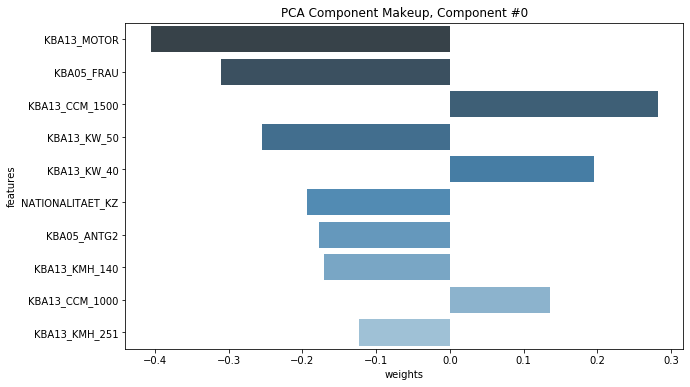

In [184]:
# display makeup of first component: component 0
num=0
display_component(v, azdias_scaled.columns.values, component_num=num, n_weights=10)

Component 0: 

- Component 0 has a high positive weight to KBA13_CCM_1500, followed by KBA13_KW_40 and then KBA13_CCM_1000
- Component 0 has a high negative weight to KBA13_MOTOR, followed by KBA05_FRAU and KBA13_KW_50

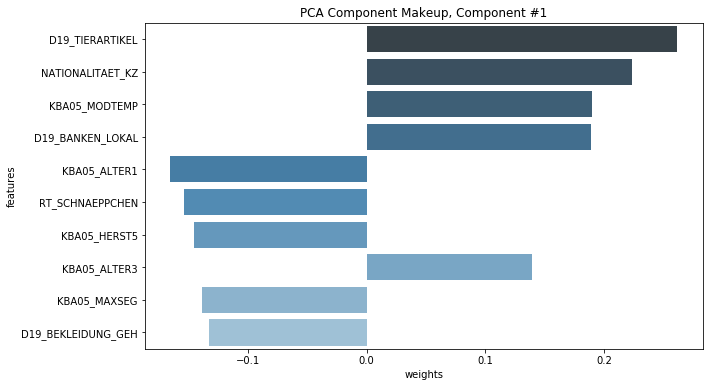

In [185]:
# display makeup of first component: component 1
num=1
display_component(v, azdias_scaled.columns.values, component_num=num, n_weights=10)

Component 1: 

- Component 1 has a high positive weight to D19_TIERARTIKEL, followed by NATIONALITAET_KZ and then KBA05_MODTEMP and D19_BANKEN_LOKAL
- Component 1 has a high negative weight to KBA05_ALTER1, followed by RT_SCHNAEPPCHEN and KBA05_HERST5

# Part 2: K-Means Clusting

## Training the K-Means model with various numbers of cluster

In [311]:
azdias_transformed_train_data = azdias_PCA_98_transformed_df.values.astype('float32')

In [192]:
from sagemaker import KMeans, get_execution_role

K = range(2, 12)
job_names_path = []

for k in K:
    print('Starting KMeans training job: ' + str(k))    
    output_path = 's3://{}/{}/kmeans/train/{}'.format(bucket, prefix, str(k))
    print('Training artifacts will be uploaded to: {}'.format(output_location))
    
    
    kmeans = KMeans(role=get_execution_role(),
                    train_instance_count=2,
                    train_instance_type='ml.c4.xlarge',
                    output_path='s3://{}/{}/kmeans/train/{}'.format(bucket, prefix, str(k)),                    
                    k=k)
    kmeans.fit(kmeans.record_set(azdias_transformed_train_data))
    
    job_names_path.append(output_path)

Starting KMeans training job: 2
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:06:59 Starting - Starting the training job...
2020-11-03 04:07:01 Starting - Launching requested ML instances......
2020-11-03 04:08:17 Starting - Preparing the instances for training.........
2020-11-03 04:09:43 Downloading - Downloading input data...
2020-11-03 04:10:10 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:10:35 INFO 140373069317952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'loc

[11/03/2020 04:10:35 INFO 140373069317952] nvidia-smi took: 0.0251920223236 secs to identify 0 gpus
[11/03/2020 04:10:35 INFO 140373069317952] Number of GPUs being used: 0
[11/03/2020 04:10:35 INFO 140373069317952] Setting up with params: {u'_tuning_objective_metric': u'', u'extra_center_factor': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'True', u'epochs': u'1', u'feature_dim': u'98', u'local_lloyd_tol': u'0.0001', u'_disable_wait_to_read': u'false', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'_enable_profiler': u'false', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'init_method': u'random', u'half_life_time_size': u'0', u'local_lloyd_max_iter': u'300', u'_kvstore': u'auto', u'k': u'2', u'_num_slices': u'1'}
[11/03/2020 04:10:35 INFO 140373069317952] 'extra_center_factor' was set to 'auto', evaluated to 10.
[11/03/2020 04:10:35 INFO 140373069317952] Number of GPUs being used: 0
[11


2020-11-03 04:10:44 Uploading - Uploading generated training model
2020-11-03 04:10:44 Completed - Training job completed
Training seconds: 122
Billable seconds: 122
Starting KMeans training job: 3
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:11:20 Starting - Starting the training job...
2020-11-03 04:11:23 Starting - Launching requested ML instances......
2020-11-03 04:12:42 Starting - Preparing the instances for training.........
2020-11-03 04:14:18 Downloading - Downloading input data...
2020-11-03 04:14:50 Training - Training image download completed. Training in progress.
2020-11-03 04:14:50 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:14:42 INFO 140035274188608] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_llo

[11/03/2020 04:14:46 INFO 140035274188608] Launching parameter server for role scheduler
[11/03/2020 04:14:46 INFO 140035274188608] {'ECS_CONTAINER_METADATA_URI': 'http://169.254.170.2/v3/1d132f85-16ef-4306-9d1c-2268c7991aa7', 'ECS_CONTAINER_METADATA_URI_V4': 'http://169.254.170.2/v4/1d132f85-16ef-4306-9d1c-2268c7991aa7', 'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION_VERSION': '2', 'PATH': '/opt/amazon/bin:/usr/local/nvidia/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/amazon/bin:/opt/amazon/bin', 'SAGEMAKER_HTTP_PORT': '8080', 'HOME': '/root', 'PYTHONUNBUFFERED': 'TRUE', 'CANONICAL_ENVROOT': '/opt/amazon', 'LD_LIBRARY_PATH': '/opt/amazon/lib/python2.7/site-packages/cv2/../../../../lib:/usr/local/nvidia/lib64:/opt/amazon/lib', 'MXNET_KVSTORE_BIGARRAY_BOUND': '400000000', 'LANG': 'en_US.utf8', 'DMLC_INTERFACE': 'eth0', 'SHLVL': '1', 'AWS_REGION': 'us-east-1', 'SAGEMAKER_METRICS_DIRECTORY': '/opt/ml/output/metrics/sagemaker', 'NVIDIA_VISIBLE_DEVICES': 'void', 'TRAINING_


2020-11-03 04:14:58 Completed - Training job completed
Training seconds: 80
Billable seconds: 80
Starting KMeans training job: 4
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:15:42 Starting - Starting the training job...
2020-11-03 04:15:45 Starting - Launching requested ML instances.........
2020-11-03 04:17:17 Starting - Preparing the instances for training.........
2020-11-03 04:18:58 Downloading - Downloading input data
2020-11-03 04:18:58 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:19:15 INFO 139852619269952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u

Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:19:21 INFO 139852619269952] nvidia-smi took: 0.0251801013947 secs to identify 0 gpus
[11/03/2020 04:19:21 INFO 139852619269952] Number of GPUs being used: 0
[11/03/2020 04:19:21 INFO 139852619269952] Setting up with params: {u'_tuning_objective_metric': u'', u'extra_center_factor': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'True', u'epochs': u'1', u'feature_dim': u'98', u'local_lloyd_tol': u'0.0001', u'_disable_wait_to_read': u'false', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'_enable_profiler': u'false', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'init_method': u'random', u'half_life_time_size': u'0', u'local_lloyd_max_iter': u'300', u'_kvstore': u'auto', u'k': u'4', u'_num_slices': u'1'}
[11/03/2020 04:19:21 INFO 139852619269952] 'extra_center_factor' was set to 'a


2020-11-03 04:19:31 Uploading - Uploading generated training model
2020-11-03 04:19:31 Completed - Training job completed
Training seconds: 88
Billable seconds: 88
Starting KMeans training job: 5
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:20:04 Starting - Starting the training job...
2020-11-03 04:20:07 Starting - Launching requested ML instances......
2020-11-03 04:21:22 Starting - Preparing the instances for training.........
2020-11-03 04:22:55 Downloading - Downloading input data...
2020-11-03 04:23:18 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:23:42 INFO 140427943438144] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', 


2020-11-03 04:23:57 Uploading - Uploading generated training model
2020-11-03 04:23:57 Completed - Training job completed
Training seconds: 124
Billable seconds: 124
Starting KMeans training job: 6
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:24:27 Starting - Starting the training job...
2020-11-03 04:24:29 Starting - Launching requested ML instances.........
2020-11-03 04:26:01 Starting - Preparing the instances for training......
2020-11-03 04:27:27 Downloading - Downloading input data...
2020-11-03 04:27:39 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:28:02 INFO 139757983496000] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'loc

[11/03/2020 04:28:04 INFO 139924705838912] nvidia-smi took: 0.0251770019531 secs to identify 0 gpus
[11/03/2020 04:28:04 INFO 139924705838912] Number of GPUs being used: 0
[11/03/2020 04:28:04 INFO 139924705838912] Setting up with params: {u'_tuning_objective_metric': u'', u'extra_center_factor': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'True', u'epochs': u'1', u'feature_dim': u'98', u'local_lloyd_tol': u'0.0001', u'_disable_wait_to_read': u'false', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'_enable_profiler': u'false', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'init_method': u'random', u'half_life_time_size': u'0', u'local_lloyd_max_iter': u'300', u'_kvstore': u'auto', u'k': u'6', u'_num_slices': u'1'}
[11/03/2020 04:28:04 INFO 139924705838912] 'extra_center_factor' was set to 'auto', evaluated to 10.
[11/03/2020 04:28:04 INFO 139924705838912] Number of GPUs being used: 0
[11


2020-11-03 04:28:20 Uploading - Uploading generated training model
2020-11-03 04:28:20 Completed - Training job completed
Training seconds: 106
Billable seconds: 106
Starting KMeans training job: 7
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:28:49 Starting - Starting the training job...
2020-11-03 04:28:51 Starting - Launching requested ML instances.........
2020-11-03 04:30:28 Starting - Preparing the instances for training.........
2020-11-03 04:32:13 Downloading - Downloading input data
2020-11-03 04:32:13 Training - Downloading the training image...
2020-11-03 04:32:50 Uploading - Uploading generated training model
2020-11-03 04:32:50 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:32:38 INFO 140299419445056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_me

Training seconds: 90
Billable seconds: 90
Starting KMeans training job: 8
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:33:11 Starting - Starting the training job...
2020-11-03 04:33:13 Starting - Launching requested ML instances.........
2020-11-03 04:34:44 Starting - Preparing the instances for training.........
2020-11-03 04:36:32 Downloading - Downloading input data
2020-11-03 04:36:32 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:36:55 INFO 139730169075520] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', 


2020-11-03 04:37:06 Uploading - Uploading generated training model
2020-11-03 04:37:06 Completed - Training job completed
Training seconds: 98
Billable seconds: 98
Starting KMeans training job: 9
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:37:33 Starting - Starting the training job...
2020-11-03 04:37:35 Starting - Launching requested ML instances.........
2020-11-03 04:39:04 Starting - Preparing the instances for training.........
2020-11-03 04:41:01 Downloading - Downloading input data
2020-11-03 04:41:01 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:41:19 INFO 140164820739904] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', 

Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:41:32 INFO 140149504014144] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[11/03/2020 04:41:32 INFO 140149504014144] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'98', u'k': u'9', u'force_dense': u'True'}
[11/03/2020


2020-11-03 04:41:45 Uploading - Uploading generated training model
2020-11-03 04:41:45 Completed - Training job completed
Training seconds: 112
Billable seconds: 112
Starting KMeans training job: 10
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:42:25 Starting - Starting the training job...
2020-11-03 04:42:27 Starting - Launching requested ML instances......
2020-11-03 04:43:45 Starting - Preparing the instances for training.........
2020-11-03 04:45:19 Downloading - Downloading input data
2020-11-03 04:45:19 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:45:36 INFO 140007797565248] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'e


2020-11-03 04:45:49 Uploading - Uploading generated training model[11/03/2020 04:45:42 INFO 140007797565248] Launching parameter server for role scheduler
[11/03/2020 04:45:42 INFO 140007797565248] {'ECS_CONTAINER_METADATA_URI': 'http://169.254.170.2/v3/b83758dc-f0c7-4923-876b-9fefcbc59f9a', 'ECS_CONTAINER_METADATA_URI_V4': 'http://169.254.170.2/v4/b83758dc-f0c7-4923-876b-9fefcbc59f9a', 'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION_VERSION': '2', 'PATH': '/opt/amazon/bin:/usr/local/nvidia/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/amazon/bin:/opt/amazon/bin', 'SAGEMAKER_HTTP_PORT': '8080', 'HOME': '/root', 'PYTHONUNBUFFERED': 'TRUE', 'CANONICAL_ENVROOT': '/opt/amazon', 'LD_LIBRARY_PATH': '/opt/amazon/lib/python2.7/site-packages/cv2/../../../../lib:/usr/local/nvidia/lib64:/opt/amazon/lib', 'MXNET_KVSTORE_BIGARRAY_BOUND': '400000000', 'LANG': 'en_US.utf8', 'DMLC_INTERFACE': 'eth0', 'SHLVL': '1', 'AWS_REGION': 'us-east-1', 'SAGEMAKER_METRICS_DIRECTORY': '/opt/ml/outp


2020-11-03 04:45:57 Completed - Training job completed
Training seconds: 112
Billable seconds: 112
Starting KMeans training job: 11
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/kmeans/train/2


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 04:46:46 Starting - Starting the training job...
2020-11-03 04:46:48 Starting - Launching requested ML instances......
2020-11-03 04:48:04 Starting - Preparing the instances for training.........
2020-11-03 04:49:41 Downloading - Downloading input data...
2020-11-03 04:50:16 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 04:50:12 INFO 139642329347904] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_c


2020-11-03 04:50:34 Uploading - Uploading generated training model
2020-11-03 04:50:34 Completed - Training job completed
Training seconds: 106
Billable seconds: 106


In [195]:
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

Arvato/Input/Azdias/
Arvato/Input/Azdias/Azdias_cleaned.csv
Arvato/Input/Azdias/Azdias_scaled.csv
Arvato/Input/DIAS Attributes - Values 2017.xlsx
Arvato/Input/DIAS Information Levels - Attributes 2017.xlsx
Arvato/Input/Udacity_AZDIAS_052018.csv
Arvato/Input/Udacity_CUSTOMERS_052018.csv
Arvato/Input/Udacity_MAILOUT_052018_TEST.csv
Arvato/Input/Udacity_MAILOUT_052018_TRAIN.csv
Arvato/Output/kmeans-2020-10-26-04-47-52-970/output/model.tar.gz
Arvato/Output/kmeans-2020-10-27-05-04-21-294/output/model.tar.gz
Arvato/Output/kmeans-2020-10-27-05-12-32-506/output/model.tar.gz
Arvato/Output/kmeans-2020-10-27-05-37-47-120/output/model.tar.gz
Arvato/Output/pca-2020-10-24-22-10-29-809/output/model.tar.gz
Arvato/Output/pca-2020-10-24-23-58-19-122/output/model.tar.gz
Arvato/Output/pca-2020-10-25-01-16-34-554/output/model.tar.gz
Arvato/Output/pca-2020-10-25-02-56-36-264/output/model.tar.gz
Arvato/Output/pca-2020-10-25-14-17-30-004/output/model.tar.gz
Arvato/Output/pca-2020-10-25-15-45-33-171/output/mod

## Plot Elbow graph and choose the reasonably good number of cluster

sagemaker/arvato-batch/kmeans/train/2/kmeans-2020-11-03-04-06-58-956/output/model.tar.gz
Model for k=2 (sagemaker/arvato-batch/kmeans/train/2/kmeans-2020-11-03-04-06-58-956/output/model.tar.gz)
state_e741449f-2d02-4fb2-a95a-852e2a5c3f59
model_algo-1
state_551b9ada-0d1a-4f51-a6f6-fa79ed99083d
sagemaker/arvato-batch/kmeans/train/3/kmeans-2020-11-03-04-11-20-674/output/model.tar.gz
Model for k=3 (sagemaker/arvato-batch/kmeans/train/3/kmeans-2020-11-03-04-11-20-674/output/model.tar.gz)
state_0ead6758-dc13-40a2-af1f-90358ce85b51
model_algo-1
state_a3561799-ba7f-4e4e-9671-816527e94bc9
sagemaker/arvato-batch/kmeans/train/4/kmeans-2020-11-03-04-15-42-651/output/model.tar.gz
Model for k=4 (sagemaker/arvato-batch/kmeans/train/4/kmeans-2020-11-03-04-15-42-651/output/model.tar.gz)
state_a4732a60-380a-4507-b618-7dd66fd37161
model_algo-1
state_622426ac-7e3e-47af-b967-daaebd06ae61
sagemaker/arvato-batch/kmeans/train/5/kmeans-2020-11-03-04-20-04-614/output/model.tar.gz
Model for k=5 (sagemaker/arvato-

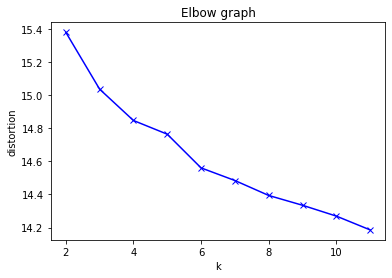

In [204]:
import mxnet as mx
from scipy.spatial.distance import cdist

plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []
output_path_list = ["kmeans-2020-11-03-04-06-58-956",
                    "kmeans-2020-11-03-04-11-20-674",
                    "kmeans-2020-11-03-04-15-42-651",
                    "kmeans-2020-11-03-04-20-04-614",
                    "kmeans-2020-11-03-04-24-27-524",
                    "kmeans-2020-11-03-04-28-49-766",
                    "kmeans-2020-11-03-04-33-11-441",
                    "kmeans-2020-11-03-04-37-32-808",
                    "kmeans-2020-11-03-04-42-24-990",
                    "kmeans-2020-11-03-04-46-46-711"]




for k in K:
    training_job_name = output_path_list[k-2]
    s3_client = boto3.client('s3')
    model_key = output_path
    model_key = os.path.join(prefix, 'kmeans/train', str(k), training_job_name, 'output/model.tar.gz')
    print(model_key)
    
    s3_client.download_file(bucket, model_key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, model_key))
    !tar -xvf model.tar.gz
       
    kmeans_model_params = mx.ndarray.load('model_algo-1')
    
    kmeans_numpy = kmeans_model_params[0].asnumpy()
    distortions.append(sum(np.min(cdist(azdias_transformed_train_data, kmeans_numpy, 'euclidean'), axis=1)) / azdias_transformed_train_data.shape[0])
    models[k] = kmeans_numpy
    
    #cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
    #cluster_centroids.columns = [i for i in range(1, 31)]
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()



### The Euclidean distance to the cluster centroid was plot. The error decreases as k gets larger. This is because when the number of clusters increases, they should be smaller, so distortion is also smaller. This produces an “elbow effect” in the graph. The idea of the elbow method is to choose the k at which the rate of decrease sharply shifts. Based on the graph above, k=6 would be a good cluster size for this dataset. 

## Train the K-Means model with 6 clusers

In [223]:
from sagemaker import KMeans, get_execution_role

kmeans_k6 = KMeans(role=get_execution_role(),
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://{}/{}/kmeans/train/k6'.format(bucket, prefix),
                k=6)

In [224]:
%%time
kmeans_k6.fit(kmeans_k6.record_set(azdias_transformed_train_data))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-03 05:40:33 Starting - Starting the training job...
2020-11-03 05:40:35 Starting - Launching requested ML instances.........
2020-11-03 05:42:07 Starting - Preparing the instances for training......
2020-11-03 05:43:22 Downloading - Downloading input data
2020-11-03 05:43:22 Training - Downloading the training image...
2020-11-03 05:43:59 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2020 05:43:57 INFO 140587024803648] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_d


2020-11-03 05:44:06 Completed - Training job completed
Training seconds: 61
Billable seconds: 61
CPU times: user 8.44 s, sys: 276 ms, total: 8.72 s
Wall time: 4min 22s


In [50]:
#Get the name of the training job for k=6
training_job_name="kmeans-2020-11-03-04-24-27-524"
k=6

#where the model is saved, by default
model_key = os.path.join(prefix, 'kmeans/train', str(k), training_job_name,  'output/model.tar.gz')
print(model_key)

#download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

#unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

sagemaker/arvato-batch/kmeans/train/6/kmeans-2020-11-03-04-24-27-524/output/model.tar.gz


2304

## Retrieve K-Means transformed data with 6 clusters and save them as local files 

In [51]:
import mxnet as mx

kmeans_k6_model_params = mx.ndarray.load('model_algo-1')

In [52]:
# what are the params
print(kmeans_k6_model_params)

[
[[-2.04750262e-02 -2.28035655e-02 -8.16782471e-03 -2.13502049e-02
  -1.41997263e-02 -4.84055504e-02 -2.61378624e-02  7.64040835e-03
   6.77530887e-03 -9.10308026e-03  1.26346257e-02  6.81978092e-03
   3.15929465e-02 -4.54912744e-02 -4.14106026e-02  9.38848779e-03
  -1.27576590e-02  2.99017448e-02 -7.57541135e-03  1.59253404e-02
  -1.02932602e-02  1.86371990e-03  2.29512863e-02  6.04361854e-02
   3.58284786e-02 -4.40464839e-02  5.40308841e-02  4.40291539e-02
   5.48911430e-02  4.47366647e-02  7.40922093e-02 -1.91914253e-02
  -9.25575197e-02 -5.30023314e-02  3.75105888e-02 -1.57025456e-03
   3.48562934e-02  3.01124863e-02 -4.51320261e-02  3.45866382e-03
   1.00865923e-01  1.32056549e-02 -2.93361098e-02  3.35002020e-02
  -5.71852699e-02 -4.22049649e-02  2.91437656e-03  7.47685432e-02
   2.08543986e-03  5.58275506e-02  3.52119654e-03 -1.26726963e-02
   2.30054557e-02  8.04992542e-02 -1.58098787e-02  3.04897465e-02
   4.27598357e-02  3.03170457e-02 -1.65534839e-02  5.14397919e-02
  -1.252

In [53]:
cluster_centroids = pd.DataFrame(kmeans_k6_model_params[0].asnumpy())
cluster_centroids.columns = [i for i in range(1, 99)]

In [54]:
cluster_centroids

1         2         3         4         5         6         7   \
0 -0.020475 -0.022804 -0.008168 -0.021350 -0.014200 -0.048406 -0.026138   
1 -0.023248 -0.071283  0.025079  0.035558  0.009322  0.001819  0.029923   
2 -0.012212  0.015618  0.061918 -0.025278  0.023572  0.031368  0.009064   
3 -0.009467  0.085804 -0.050888  0.069764 -0.067947 -0.027344  0.001419   
4  0.019856 -0.006500 -0.022760  0.006373  0.011742  0.050319  0.002574   
5  0.126647 -0.074933  0.024024  0.114280 -0.132602 -0.037069 -0.098108   

         8         9         10  ...        89        90        91        92  \
0  0.007640  0.006775 -0.009103  ...  0.359251  0.654519 -0.254629 -0.165522   
1  0.020224  0.009764 -0.000302  ... -0.000775  0.225308 -0.163275  0.052795   
2 -0.022502  0.014693  0.038792  ...  0.081614  0.395223 -0.077122 -0.304349   
3  0.027038  0.004180 -0.009633  ... -0.288598 -0.576966  0.154819  0.259859   
4 -0.013235  0.027972 -0.008510  ... -0.133175 -0.324994  0.091420  0.337478   
5 -0.050106 -0.150734  0.013580  ...  0.251995 -0.864092  0.276550 -0.687143   

         93        94        95        96        97        98  
0  0.518061 -0.019327 -3.153087  2.356041  2.437376  3.860394  
1  0.202674  0.365491 -1.115796 -0.301095 -4.125447 -5.906120  
2 -0.001830 -0.525777  4.792738 -0.626182  0.334534  0.239027  
3 -0.359944 -0.171272  0.300551  1.710835  3.611753 -3.428887  
4 -0.239707  0.384582  0.288957 -0.654869 -2.414217  5.745503  
5 -0.103460 -1.080415 -2.253875 -7.328400  3.127422 -1.117238  

[6 rows x 98 columns]

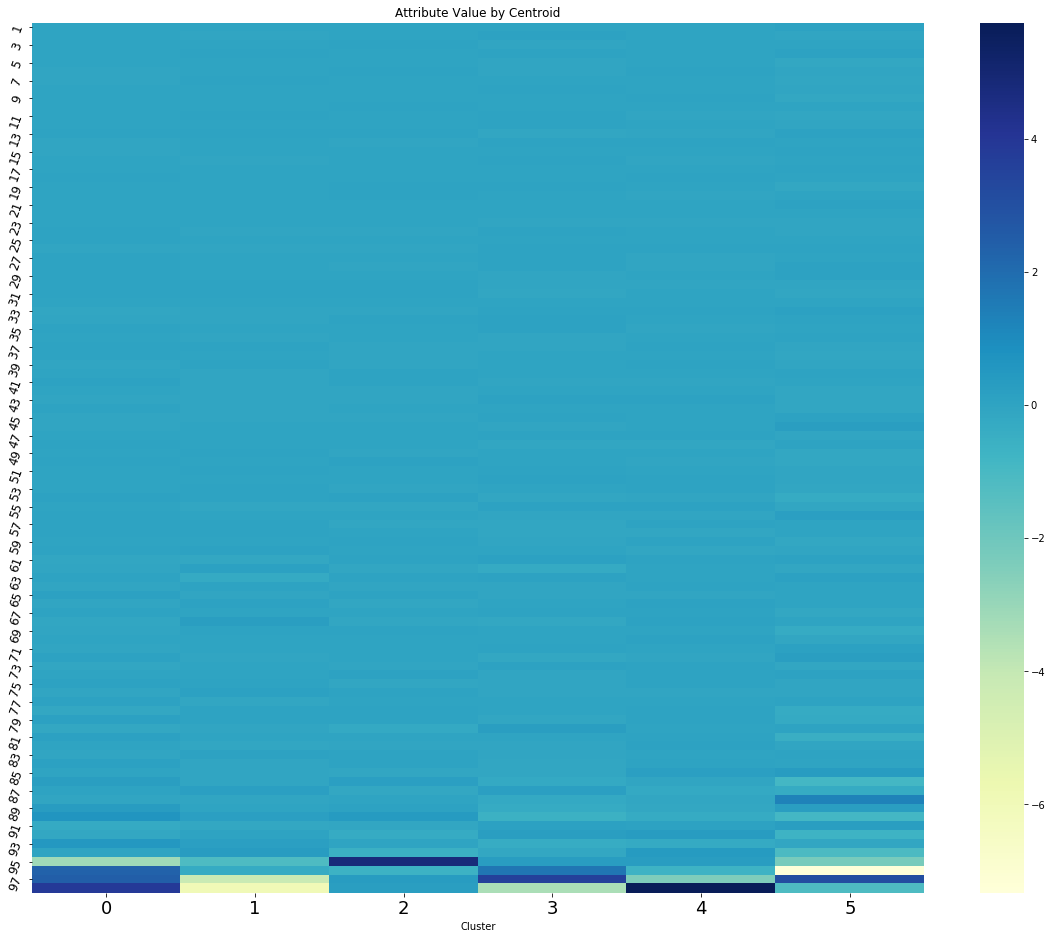

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize = (20, 16))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 12)
plt.yticks(rotation=70)
plt.xticks(fontsize = 18)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [312]:
# Use fitted estimator directly
kmeans_k6_transformer = kmeans_k6.transformer(instance_count=1,
                                    instance_type='ml.c4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: kmeans-2020-11-03-05-40-33-544


In [313]:
train_PCA_98_transform_s3 = sess.upload_data('./data/PCA_98_transformed/azdias_PCA_98_transformed.csv', 
                            bucket=bucket, 
                            key_prefix='{}/pca_batch/output/PCA_98_transform_csv'.format(prefix))

In [314]:
train_PCA_98_transform_s3_input = sagemaker.s3_input(train_PCA_98_transform_s3, content_type='text/csv; label_size=0')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [315]:
kmeans_k6_transformer.transform(data=train_PCA_98_transform_s3, 
                      #data_type='S3Prefix',
                      content_type='text/csv',
                      split_type='Line')

In [316]:
kmeans_k6_transformer.wait()

...............................2020-11-03T08:10:58.095:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2020 08:10:57 INFO 140205213415232] loading entry points
[11/03/2020 08:10:57 INFO 140205213415232] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[11/03/2020 08:10:57 INFO 140205213415232] loaded request iterator text/csv
[11/03/2020 08:10:57 INFO 140205213415232] loaded request iterator application/x-recordio-protobuf
[11/03/2020 08:10:57 INFO 140205213415232] loaded request iterator application/json
[11/03/2020 08:10:57 INFO 140205213415232] loaded request iterator application/jsonlines
[11/03/2020 08:10:58 INFO 140205213415232] loaded response encoder text/csv
[11/03/2020 08:10:58 INFO 140205213415232] loaded response encoder application/x-recordio-protobuf
[11/03/2020

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604391063.076772, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1604391062.348967}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.018835067749023438, "sum": 0.018835067749023438, "min": 0.018835067749023438}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604391063.237643, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "KMeansModel"}, "StartTime": 1604391062.437623}

#metrics {"Metrics": {"model.evaluate.time": {"count": 1, "max": 0.01811981201171875, "sum": 0.01811981201171875, "min": 0.01811981201171875}, "invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1604391063.076772, "Dimensions": {"Host": "UNKNOWN", 

In [317]:
!aws s3 cp --recursive $kmeans_k6_transformer.output_path ./

download: s3://sagemaker-us-east-1-873710589365/kmeans-2020-11-03-08-05-54-536/azdias_PCA_98_transformed.csv.out to ./azdias_PCA_98_transformed.csv.out


In [318]:
!head -c 10000 azdias_PCA_98_transformed.csv.out

{"closest_cluster": 3.0, "distance_to_cluster": 18.43915367126465}
{"closest_cluster": 3.0, "distance_to_cluster": 12.103960037231445}
{"closest_cluster": 2.0, "distance_to_cluster": 11.946063995361328}
{"closest_cluster": 0.0, "distance_to_cluster": 18.73617172241211}
{"closest_cluster": 2.0, "distance_to_cluster": 12.439842224121094}
{"closest_cluster": 3.0, "distance_to_cluster": 11.842074394226074}
{"closest_cluster": 3.0, "distance_to_cluster": 12.66797161102295}
{"closest_cluster": 2.0, "distance_to_cluster": 13.406730651855469}
{"closest_cluster": 0.0, "distance_to_cluster": 19.58176040649414}
{"closest_cluster": 1.0, "distance_to_cluster": 15.28470516204834}
{"closest_cluster": 3.0, "distance_to_cluster": 13.319694519042969}
{"closest_cluster": 3.0, "distance_to_cluster": 10.99112319946289}
{"closest_cluster": 2.0, "distance_to_cluster": 16.213186264038086}
{"closest_cluster": 1.0, "distance_to_cluster": 13.893882751464844}
{"closest_cluster": 3.0, "distance_to_cluster": 13.290

In [350]:
azdias_kmeans_cluster = []
with open('./azdias_PCA_98_transformed.csv.out', 'r') as f:
    for line in f:
        result = json.loads(line)["closest_cluster"]
        azdias_kmeans_cluster.append(result)

In [351]:
azdias_kmeans_cluster_df = pd.DataFrame (azdias_kmeans_cluster)
print (azdias_kmeans_cluster_df)

          0
0       3.0
1       3.0
2       2.0
3       0.0
4       2.0
...     ...
241109  4.0
241110  1.0
241111  1.0
241112  3.0
241113  1.0

[241114 rows x 1 columns]


In [352]:
cluster_dir = 'data/cluster'

if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

azdias_kmeans_cluster_df.to_csv('./data/cluster/azdias_kmeans_cluster.csv', header=False, index=False)

In [353]:
def load_transformed(): 
    azdias = pd.read_csv('./data/PCA_98_transformed/azdias_PCA_98_transformed.csv', sep=',')
    customers = pd.read_csv('./data/PCA_98_transformed/customers_PCA_98_transformed.csv', sep=',')
    return azdias, customers

In [354]:
azdias_PCA_98_transformed, customers_PCA_98_transformed = load_transformed()

In [355]:
azdias_PCA_98_transformed

-0.606203913688659  -0.122721664607524  0.119107574224472  \
0                 0.442662           -0.706085          -0.445722   
1                -0.642516           -0.418196          -0.344248   
2                -1.449587           -1.516623           1.889028   
3                -0.426649           -0.263285          -0.394847   
4                -0.801652           -0.818311          -0.927978   
...                    ...                 ...                ...   
241108            0.869102            0.130130          -0.136358   
241109           -2.352255           -0.649834          -0.372760   
241110            0.370154           -0.371740          -0.282963   
241111           -0.541074            0.473046          -0.315009   
241112           -0.538707            0.580104          -0.117044   

        -0.166285648941993  -0.247060239315032  0.340385288000106  \
0                -1.000217            0.874542          -0.307129   
1                 0.157811            0.301395           1.017755   
2                 1.418237           -0.107263          -1.070999   
3                 0.902190            0.033893           0.571411   
4                 0.640588           -1.459535          -1.977621   
...                    ...                 ...                ...   
241108           -0.608345            0.397458          -0.575874   
241109           -0.303095           -0.083134          -0.670210   
241110           -0.238608            0.358921           0.689177   
241111           -0.116104            0.061615          -0.110109   
241112           -0.062232           -0.136473          -0.399825   

        0.15248703956604  0.265095919370651  -0.313516855239868  \
0               0.254920          -0.491068            0.760658   
1              -0.297108          -0.223304            0.316671   
2               2.134528           0.101611           -0.598539   
3               0.343360          -1.811847            0.279600   
4              -0.502747           1.399415           -0.583819   
...                  ...                ...                 ...   
241108          0.314215           0.044523           -0.786523   
241109         -0.375036           0.412813           -0.070094   
241110         -1.377115          -0.192024            0.506243   
241111         -0.171413           0.102939           -0.706758   
241112         -0.142826           0.164481           -0.524687   

        0.907284617424011  ...  1.778223633766174  -0.129338860511779  \
0               -1.072608  ...          -0.827553            1.464199   
1                0.054148  ...           2.228155           -2.991797   
2               -1.937268  ...           3.862974           -0.051941   
3                0.523650  ...           2.314099            0.578058   
4               -1.439355  ...          -1.344012            0.234211   
...                   ...  ...                ...                 ...   
241108          -0.320029  ...           1.994457           -1.761734   
241109          -0.279956  ...          -3.126789           -2.722470   
241110          -0.261166  ...           1.264904            0.681833   
241111          -0.141253  ...           2.728595            2.489413   
241112           0.224589  ...           2.905778            2.928099   

        0.406978011131286  4.93699836730957  0.627387642860412  \
0               -1.726155         -3.482148           5.470273   
1               -1.395964          1.800635           0.515195   
2               -3.549787         -3.215467          -2.411659   
3               -2.429218          0.662385          -0.381398   
4                0.690074         -4.099455           4.130570   
...                   ...               ...                ...   
241108           0.579529         -2.605617          -0.768506   
241109           1.008730          2.456252           1.915185   
241110          -1.169031         -5.023602          -2.219597   
241111  

In [356]:
customers_PCA_98_transformed

-0.501911461353302  -1.015130758285522  -0.543785154819488  \
0                -0.646443            0.850091           -1.116986   
1                 1.832213           -0.190200           -0.491808   
2                -0.913548            0.819499            1.311102   
3                 0.128464            1.050099           -0.342585   
4                -0.809705            1.143324           -0.481576   
...                    ...                 ...                 ...   
134240            1.414313            0.053030           -0.517603   
134241           -1.185485            0.336754            0.390742   
134242           -0.183976           -1.059014           -0.157447   
134243           -2.056088            2.447308           -1.501450   
134244            0.912349           -0.191850            0.429351   

        0.293479710817337  0.498295396566391  0.775335490703582  \
0                1.088164          -0.394695          -0.079461   
1               -1.775110           1.345561           0.178194   
2                0.066801          -1.308979          -1.221489   
3                0.721581          -0.261940          -0.720311   
4                0.210819           0.684033           1.083486   
...                   ...                ...                ...   
134240           0.805965           0.167101           1.196180   
134241          -0.065762           0.433236          -0.213814   
134242          -0.252127          -0.385250           0.355729   
134243          -0.914446          -1.638765           1.235651   
134244          -0.942864          -0.540160           0.620760   

        1.159994721412658  -0.765816330909729  1.016798138618469  \
0               -0.179645           -0.051525          -0.396755   
1                1.354196            1.238864          -1.849359   
2                0.461979            0.990408          -1.166168   
3               -1.319384           -0.425475          -0.927181   
4               -0.184152            0.339465          -1.695093   
...                   ...                 ...                ...   
134240           0.480058           -0.901279           0.544831   
134241          -0.468929           -1.920668          -0.715632   
134242          -0.476908           -0.311275           0.254959   
134243          -0.931810            0.795927          -0.105549   
134244          -0.771971           -1.418537           0.542482   

        0.704799175262451  ...  1.419259071350097  0.677869379520416  \
0               -0.480637  ...           1.315173          -6.563126   
1                1.116282  ...           0.945965          -0.242067   
2                0.383398  ...           2.661062           2.616636   
3               -0.335239  ...           0.996176          -2.958213   
4               -1.694272  ...           4.098593          -1.118657   
...                   ...  ...                ...                ...   
134240           0.208087  ...           1.831174          -3.829835   
134241           0.133542  ...           0.440057           0.273208   
134242          -0.980651  ...          -0.625491           1.155786   
134243          -0.931704  ...          -3.302052           1.348366   
134244           0.790494  ...           1.016688           0.258319   

        -0.261368155479431  -1.230293989181518  -2.285794973373413  \
0                 2.497998           -0.108846            2.441230   
1                -4.660441            0.421507           -2.485597   
2                -0.104265           -0.739713            0.259213   
3                 0.324100           -2.033175           -1.499764   
4                -0.876298           -0.440542           -2.009474   
...                    ...                 ...                 ...   
134240            2.354343           -2.095109           -2.457608   
134241           -4.498803            2.781303            2.932752   
134242            1.375725           -0.200757    

In [326]:
customers_PCA_98_transform_s3 = sess.upload_data('./data/PCA_98_transformed/customers_PCA_98_transformed.csv', 
                            bucket=bucket, 
                            key_prefix='{}/pca_batch/customers/output/PCA_98_transform_csv'.format(prefix))

In [329]:
customers_PCA_98_transform_s3_input = sagemaker.s3_input(customers_PCA_98_transform_s3, content_type='text/csv; label_size=0')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [330]:
kmeans_k6_customers_model = sess.create_model_from_job(kmeans_k6._current_job_name, name='{}-customers'.format(kmeans_k6._current_job_name))

Using already existing model: kmeans-2020-11-03-05-40-33-544-customers


In [331]:
kmeans_k6_customers_transformer = Transformer(kmeans_k6_customers_model,
                                   1,
                                   'ml.m4.xlarge',
                                   output_path='s3://{}/{}/pca_batch/customers/kmeans/output/output'.format(bucket, prefix),
                                   sagemaker_session=sess,
                                   strategy='MultiRecord',
                                   assemble_with='Line')
kmeans_k6_customers_transformer.transform(customers_PCA_98_transform_s3, content_type='text/csv', split_type='Line')
kmeans_k6_customers_transformer.wait()

................................2020-11-03T08:26:46.898:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD

Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2020 08:26:46 INFO 140086102595392] loading entry points
[11/03/2020 08:26:46 INFO 140086102595392] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[11/03/2020 08:26:46 INFO 140086102595392] loaded request iterator text/csv
[11/03/2020 08:26:46 INFO 140086102595392] loaded request iterator application/x-recordio-protobuf
[11/03/2020 08:26:46 INFO 140086102595392] loaded request iterator application/json
[11/03/2020 08:26:46 INFO 140086102595392] loaded request iterator application/jsonlines
[11/03/2020 08:26:46 INFO 140086102595392] loaded response encoder text/csv
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/202

In [332]:
!aws s3 cp --recursive $kmeans_k6_customers_transformer.output_path ./

download: s3://sagemaker-us-east-1-873710589365/sagemaker/arvato-batch/pca_batch/customers/kmeans/output/output/customers_PCA_98_transformed.csv.out to ./customers_PCA_98_transformed.csv.out


In [333]:
!head -c 10000 customers_PCA_98_transformed.csv.out

{"closest_cluster": 2.0, "distance_to_cluster": 10.477699279785156}
{"closest_cluster": 1.0, "distance_to_cluster": 14.825082778930664}
{"closest_cluster": 5.0, "distance_to_cluster": 13.431884765625}
{"closest_cluster": 4.0, "distance_to_cluster": 16.707229614257812}
{"closest_cluster": 2.0, "distance_to_cluster": 13.197216987609863}
{"closest_cluster": 0.0, "distance_to_cluster": 12.015381813049316}
{"closest_cluster": 2.0, "distance_to_cluster": 11.445202827453613}
{"closest_cluster": 4.0, "distance_to_cluster": 20.585111618041992}
{"closest_cluster": 0.0, "distance_to_cluster": 12.736087799072266}
{"closest_cluster": 0.0, "distance_to_cluster": 14.229310035705566}
{"closest_cluster": 0.0, "distance_to_cluster": 14.874429702758789}
{"closest_cluster": 4.0, "distance_to_cluster": 16.613012313842773}
{"closest_cluster": 0.0, "distance_to_cluster": 12.607715606689453}
{"closest_cluster": 0.0, "distance_to_cluster": 17.744476318359375}
{"closest_cluster": 0.0, "distance_to_cluster": 17.

In [358]:
customers_kmeans_cluster = []
with open('./customers_PCA_98_transformed.csv.out', 'r') as f:
    for line in f:
        result = json.loads(line)["closest_cluster"]
        customers_kmeans_cluster.append(result)

In [359]:
customers_kmeans_cluster_df = pd.DataFrame (customers_kmeans_cluster)
print(customers_kmeans_cluster_df)

          0
0       2.0
1       1.0
2       5.0
3       4.0
4       2.0
...     ...
134241  2.0
134242  2.0
134243  2.0
134244  1.0
134245  0.0

[134246 rows x 1 columns]


In [360]:
cluster_dir = 'data/cluster'

if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

customers_kmeans_cluster_df.to_csv('./data/cluster/customers_cluster.csv', header=False, index=False)

## Interprete K-Means clustering by visualization

In [22]:
def load_kmeans(): 
    azdias = pd.read_csv('./data/cluster/azdias_kmeans_cluster.csv', sep=',', header=None)
    customers = pd.read_csv('./data/cluster/customers_cluster.csv', sep=',', header=None)
    return azdias, customers

In [23]:
azdias_kmeans_cluster_df, customers_kmeans_cluster_df = load_kmeans()

In [24]:
azdias_kmeans_cluster_df

0
0       3.0
1       3.0
2       2.0
3       0.0
4       2.0
...     ...
241109  4.0
241110  1.0
241111  1.0
241112  3.0
241113  1.0

[241114 rows x 1 columns]

In [33]:
azdias_cluster = pd.value_counts(azdias_kmeans_cluster_df.values.flatten())

#pd.value_counts(df.values.flatten())

In [34]:
customers_cluster = pd.value_counts(customers_kmeans_cluster_df.values.flatten())


In [35]:
cluster_info = pd.DataFrame([])

#cluster_info["population"] = azdias_kmeans_cluster_df[0].value_counts().sort_index()
#cluster_info["customers"] = customers_kmeans_cluster_df[0].value_counts().sort_index()
cluster_info["population"] = azdias_cluster
cluster_info["customers"] = customers_cluster


cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"cluster"}, inplace=True)

In [36]:
cluster_info

cluster  population  customers
0      0.0       52941      32905
1      3.0       50191      23244
2      2.0       48658      35181
3      1.0       37230      19162
4      4.0       34527      15087
5      5.0       17567       8667

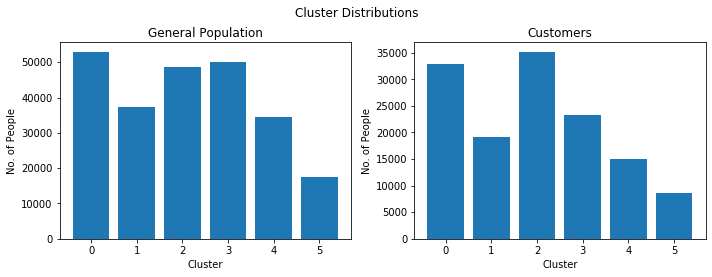

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["cluster"], cluster_info["population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["cluster"], cluster_info["customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [38]:
cluster_info["population_proportion"] = (cluster_info["population"]/cluster_info["population"].sum()*100).round(2)
cluster_info["customers_proportion"] = (cluster_info["customers"]/cluster_info["customers"].sum()*100).round(2)

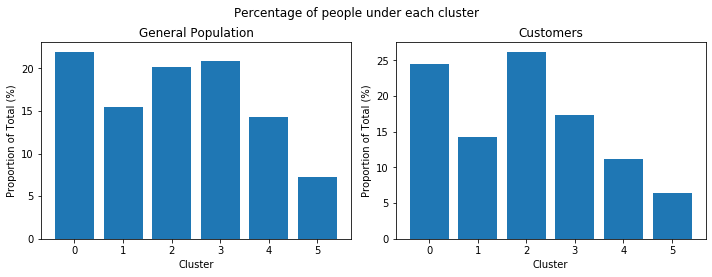

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["cluster"], cluster_info["population_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["cluster"], cluster_info["customers_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [40]:
cluster_info["customers_over_population"] = cluster_info["customers_proportion"] / cluster_info["population_proportion"]

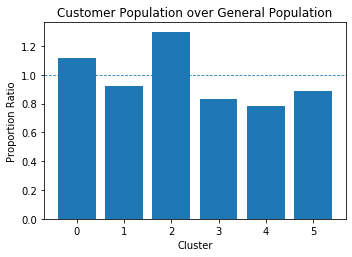

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["cluster"], cluster_info["customers_over_population"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The ratio > 1 indicates that the cluster contains more customers, and there is a scope of populations belonging to these clusters being future customers. Cluster 0 and 2 could be targeted for future customers.